# <a id='toc1_'></a>[Analysis of June 15th 2022 Flight at 1 Hz](#toc0_)

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots



## <a id='toc1_1_'></a>[Table of Contents](#toc0_)
* Importing 1 Hz Data
* Manual index masking method (1 Hz)
    * Descent mask
    * Cruising mask
* Main Analysis
    * $P_{required}$ Reduction
        * $\eta$ Steady [cl_finders.eta_steady]
        * $ C_T $ Steady [cl_finders.thrust_steady]
        * Descending [cf_finders.desc2preq]
    * $C_D$ Reduction
        * Turning power to drag coefficient [cl_finders.preq2cd]
    * CL Reduction
        * Bank angle compensated [cl_finders.cl_banked]
* Descending drag polar production
    * $C_L$, $C_D$ averaging
        * Plotting raw polar data w. errorbars
    * Curve fitting polar [cl_finders.cd2polar]
    * Standardized $P_{required}$ [cl_finders.polar2preqew]
* Cruising drag polar production
    * $C_L$, $C_D$ averaging



**Table of contents**<a id='toc0_'></a>    
- [Analysis of June 15th 2022 Flight at 1 Hz](#toc1_)    
  - [Table of Contents](#toc1_1_)    
  - [Importing packages \& Libraries](#toc1_2_)    
  - [Importing data at 1 Hz](#toc1_3_)    
  - [Defining Vehicle Parameters](#toc1_4_)    
  - [Manually defining 1 Hz Mask](#toc1_5_)    
  - [Main Analysis: $P_{req}$, $C_D$, $C_L$ Datapoints](#toc1_6_)    
  - [Descending Drag Polar Production](#toc1_7_)    
    - [Averaging $C_D$, $C_L$, Plotting](#toc1_7_1_)    
    - [Curve fitting polar [cl_finders.cd2polar]](#toc1_7_2_)    
    - [Standardized $P_{required}$ [cl_finders.polar2preqew]](#toc1_7_3_)    
  - [Cruising Drag Polar Production](#toc1_8_)    
    - [Averaging $C_D$, $C_L$, Plotting](#toc1_8_1_)    
    - [Curve fitting Polar [cl_finders.cd2polar]](#toc1_8_2_)    
    - [Standardized $P_{req}$](#toc1_8_3_)    
  - [Results Summary (Cruising \& Descending)](#toc1_9_)    
    - [Getting Angle of Attack vs $C_L$ Correlation](#toc1_9_1_)    
    - [Exporting Aerodynamic model of Vehicle](#toc1_9_2_)    
    - [Plotting $P_{req}$ vs. EAS Raw and Fitted Results](#toc1_9_3_)    
    - [Plotting C_L vs C_D, Descending and Cruising Results](#toc1_9_4_)    
  - [Time Indexed Plots](#toc1_10_)    
    - [Plotting Time Indexed data - Demanded vs True Airspeed \& Motor RPM](#toc1_10_1_)    
    - [Plotting motor RPM over the selected time intervals](#toc1_10_2_)    
    - [Plotting J to see where data needs exclusion](#toc1_10_3_)    
    - [Plotting System Efficiency](#toc1_10_4_)    
    - [Plotting Descent Rates, Zero RPM highlighted](#toc1_10_5_)    
    - [Pitch and Coefficient of Lift Time Plots](#toc1_10_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Importing packages \& Libraries](#toc0_)

In [2]:
from os import sys
import os
sys.path.append('../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

## <a id='toc1_3_'></a>[Importing data at 1 Hz](#toc0_)

In [3]:
# Importing data from BIN files #

#df = main.get_data("Alton", "june15_2022.BIN", "10ms")
#df = main.get_data("Alton", "june15_2022.BIN", "1s")

## Pickling that DF for Later ##

#df.to_pickle("./data/june15_2022.pkl")

## Unpickling 
df_100Hz = pd.read_pickle("../data/june15_2022_100Hz.pkl")
df_60Hz = pd.read_pickle("../data/june15_2022_60Hz.pkl")
df_1Hz = pd.read_pickle("../data/june15_2022_1Hz.pkl")

df = df_1Hz.interpolate(method="linear")

## <a id='toc1_4_'></a>[Defining Vehicle Parameters](#toc0_)

In [4]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

## <a id='toc1_5_'></a>[Manually defining 1 Hz Mask](#toc0_)

In [5]:
### Mask Initialization ###

mask = np.array([[9000, 9574],
                [9600, 10200],
                [10200,10900],
                [10900,11500],
                [11500,11900],
                [12800,13049],
                [13057,13350],
                [13400,13950],
                [14050,14450]])

desc_mask = np.array([[3449 , 3497],
                    [3687 , 3744],
                    [3931 , 3991],
                    [4166 , 4231],
                    [4419 , 4487],
                    [4653 , 4737],
                    [4915 , 4988],
                    [5159 , 5236],
                    [5395 , 5476],
                    [5648 , 5741],
                    [5922 , 6007],
                    [6194 , 6279],
                    [6462 , 6550],
                    [6743 , 6841],
                    [7039 , 7149],
                    [7347 , 7458],
                    [7672 , 7770],
                    [7980 , 8078],
                    [8302 , 8423],
                    [8586 , 8690]])

## <a id='toc1_6_'></a>[Main Analysis: $P_{req}$, $C_D$, $C_L$ Datapoints](#toc0_)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_55221/2104576070.py:25: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_55221/2104576070.py:25: RuntimeWarning: invalid value encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../propellers.py:114: RuntimeWarning: invalid value encountered in add
  CT = -1.636*J**5 + 3.933*J**4 - 3.246*J**3 + 0.8995*J**2 - 0.09467*J**1 + 0.08651 # (11-18 Fit, Freewheel data)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../propellers.py:122: RuntimeWarning: invalid value encountered in subtract
  CP = 0.2741*J**4 - 0.5853*J**3 + 0.3012*J**2 - 0.05987*J**1 + 0.04802 # (11-18 Fit, Freewheel data)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../motors.py:53: RuntimeWarning: divide by zero encounter

Freewheel thrust coefficient:  -0.00804445463199624 
 Advance Ratio:  0.8386905840958647 
 CP Freewheel:  5.129680916149404e-10


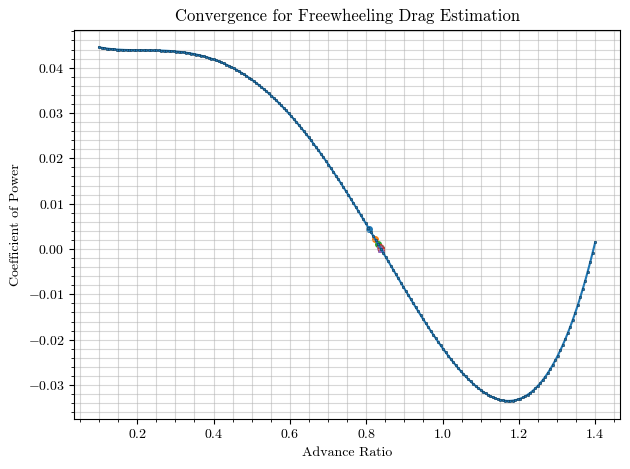

Propeller Drag[nan  0.  0. ...  0.  0.  0.]


/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:133: RuntimeWarning: divide by zero encountered in reciprocal
  CD = p_required * (q * v * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:133: RuntimeWarning: invalid value encountered in multiply
  CD = p_required * (q * v * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:33: RuntimeWarning: divide by zero encountered in reciprocal
  CL = aircraft.weight * (np.cos(phi) * q * aircraft.area)**-1


In [6]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

## <a id='toc1_7_'></a>[Descending Drag Polar Production](#toc0_)
### <a id='toc1_7_1_'></a>[Averaging $C_D$, $C_L$, Plotting](#toc0_)

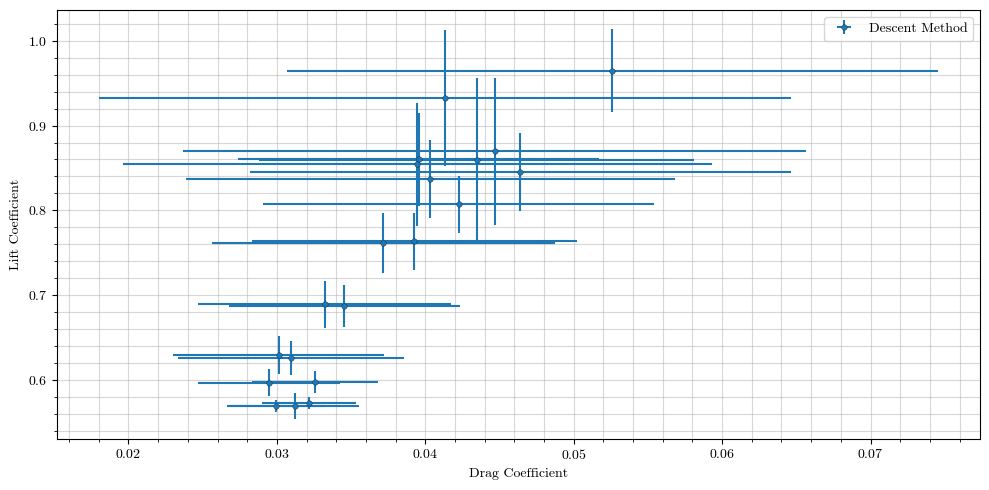

In [7]:
# Descending drag polar production
CDdesc_ave = np.zeros(len(desc_mask))
CLdesc_ave = np.zeros(len(desc_mask))
CDdesc_std = np.zeros(len(desc_mask))
CLdesc_std = np.zeros(len(desc_mask))

EASdesc_ave = np.zeros(len(desc_mask))

for i in range(len(desc_mask)):
    CDdesc_ave[i] = np.mean(Cd_desc[int(desc_mask[i,0]):int(desc_mask[i,1])])
    CLdesc_ave[i] = np.mean(CL[int(desc_mask[i,0]):int(desc_mask[i,1])])
    EASdesc_ave[i] = np.mean(v_eas[int(desc_mask[i,0]):int(desc_mask[i,1])])

    CDdesc_std[i] = np.std(Cd_desc[int(desc_mask[i,0]):int(desc_mask[i,1])])
    CLdesc_std[i] = np.std(CL[int(desc_mask[i,0]):int(desc_mask[i,1])])

plt.figure(figsize=(10,5))
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label="Descent Method")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.show()

### <a id='toc1_7_2_'></a>[Curve fitting polar [cl_finders.cd2polar]](#toc0_)

In [8]:
polar_desc = cl_finders.cd2polar(createv, CDdesc_ave, CLdesc_ave)
polar_desc

array([0.02021156, 0.65972593])

### <a id='toc1_7_3_'></a>[Standardized $P_{required}$ [cl_finders.polar2preqew]](#toc0_)

In [9]:
Peq_desc, EAS = cl_finders.polar2preqew(createv, polar_desc, (7,14))

## <a id='toc1_8_'></a>[Cruising Drag Polar Production](#toc0_)

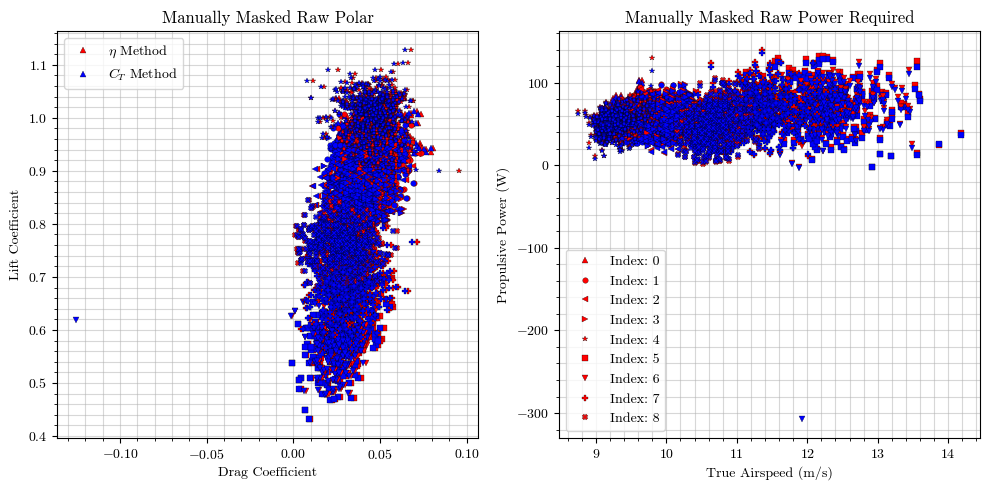

In [10]:
# Plotting Raw Polar Results + Raw Power Results
plt.figure(figsize=(10,5))
plt.subplot()
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)

ax0.set_title("Manually Masked Raw Polar")
markers = ['^', 'o', '<', '>', '*', 's', 'v', 'P', 'X', 'D', 'H']
for i in range(len(mask)):
    ax0.plot(Cd_eta[int(mask[i,0]):int(mask[i,1])], CL[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    ax0.plot(Cd_ct[int(mask[i,0]):int(mask[i,1])], CL[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("Lift Coefficient")
ax0.set_xlabel("Drag Coefficient")
ax0.legend(['$\eta$ Method', '$C_T$ Method'])

ax1.set_title("Manually Masked Raw Power Required")
for i in range(len(mask)):
    ax1.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_eta[int(mask[i,0]):int(mask[i,1])], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    ax1.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
ax1.set_xlabel("True Airspeed (m/s)")
ax1.set_ylabel("Propulsive Power (W)")
ax1.legend()
plt.show()

### <a id='toc1_8_1_'></a>[Averaging $C_D$, $C_L$, Plotting](#toc0_)

In [11]:
# Cruising averaging
CDct_ave = np.zeros(len(mask))
CDeta_ave = np.zeros(len(mask))

CL_ave = np.zeros(len(mask))
EAS_ave = np.zeros(len(mask))

pitch_ave = np.zeros(len(mask))

CDct_std = np.zeros(len(mask))
CDeta_std = np.zeros(len(mask))
CL_std = np.zeros(len(mask))

for i in range(len(mask)):
    
    CDeta_ave[i] = np.mean(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_ave[i] = np.mean(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_ave[i] = np.mean(CL[int(mask[i,0]):int(mask[i,1])])
    EAS_ave[i] = np.mean(v_eas[int(mask[i,0]):int(mask[i,1])])
    pitch_ave[i] = np.mean(pitch[int(mask[i,0]):int(mask[i,1])])
    
    CDeta_std[i] = np.std(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_std[i] = np.std(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_std[i] = np.std(CL[int(mask[i,0]):int(mask[i,1])])

### <a id='toc1_8_2_'></a>[Curve fitting Polar [cl_finders.cd2polar]](#toc0_)

In [12]:
# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave)

### <a id='toc1_8_3_'></a>[Standardized $P_{req}$](#toc0_)

In [13]:
# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (8,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (8,14))

## <a id='toc1_9_'></a>[Results Summary (Cruising \& Descending)](#toc0_)

### <a id='toc1_9_1_'></a>[Getting Angle of Attack vs $C_L$ Correlation](#toc0_)

In [14]:
# Finding AOA correlation to Coefficient of Lift:
CL_alpha = cl_finders.angleModel(CL_ave, pitch_ave, "linear")

### <a id='toc1_9_2_'></a>[Exporting Aerodynamic model of Vehicle](#toc0_)

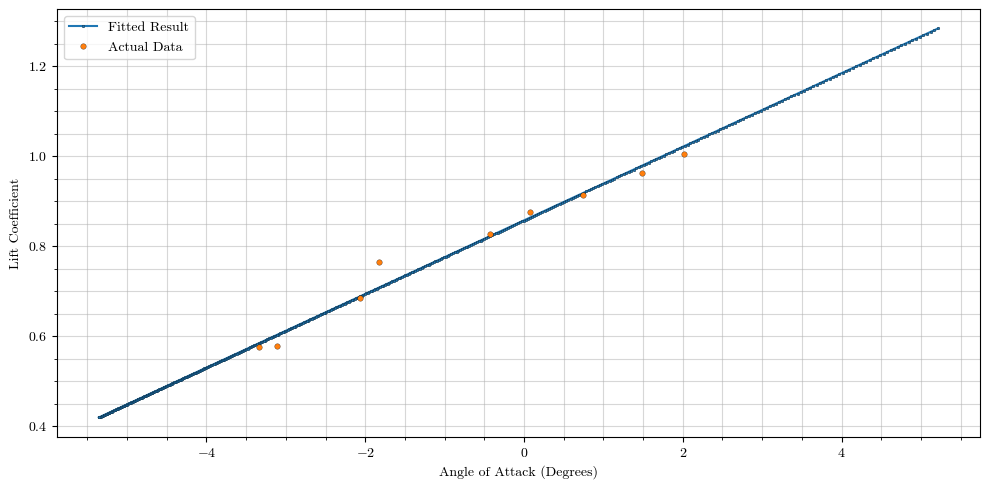

In [15]:
# Exporting aerodynamic model of vehicle (C_T)
EAS_model, CL_model, CD_model, AoA_model = cl_finders.basicModel(createv, polar_ct, CL_alpha, (8,14))
export = np.transpose(np.vstack((EAS_model, CD_model, CL_model, AoA_model)))
tmp =  {'data': export}
scipy.io.savemat('simpleModel.mat', {'data': export})

plt.figure(figsize=(10,5))
plt.plot(AoA_model, CL_model, label='Fitted Result')
plt.plot(np.rad2deg(pitch_ave), CL_ave, linestyle='None', marker='o', label='Actual Data')
plt.legend()
plt.xlabel("Angle of Attack (Degrees)")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()

### <a id='toc1_9_3_'></a>[Plotting $P_{req}$ vs. EAS Raw and Fitted Results](#toc0_)

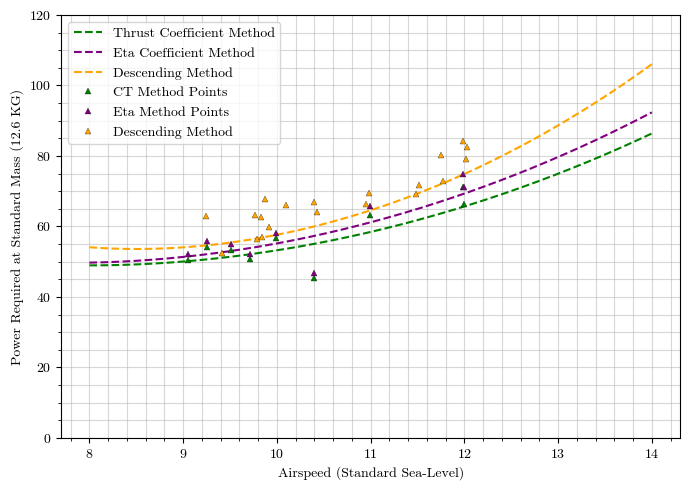

In [21]:
# Plotting P_req vs EAS, Descending and Cruising Results
plt.figure(figsize=(7,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method", color='green', linestyle='--', marker='')
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method", color='purple', linestyle='--', marker='')
plt.plot(EAS, Peq_desc, label="Descending Method", color='orange', linestyle='--', marker='')
plt.plot(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='green', markeredgecolor=[0,0,0], label='CT Method Points')
plt.plot(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='purple', markeredgecolor=[0,0,0], label='Eta Method Points')
plt.plot(EASdesc_ave, CDdesc_ave * 0.5 * 1.225 * EASdesc_ave**3 * createv.area, linestyle='', color='orange', marker='^', markeredgecolor=[0,0,0], label='Descending Method')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.ylim([0, 120])
plt.legend()

plt.show()

### <a id='toc1_9_4_'></a>[Plotting C_L vs C_D, Descending and Cruising Results](#toc0_)

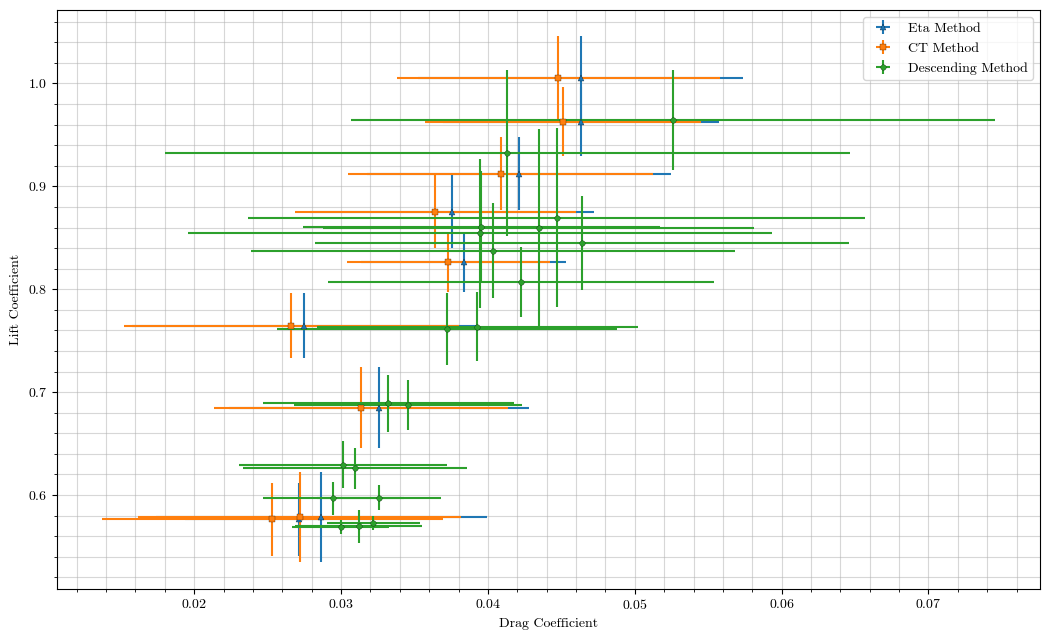

In [22]:
# Plotting C_L vs C_D, Descending and Cruising Results
plt.figure(figsize=(10.6,6.5), dpi=100)
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='^', label="Eta Method", markeredgecolor=[0,0,0])
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='s', label="CT Method", markeredgecolor=[0,0,0])
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label = "Descending Method", markeredgecolor=[0,0,0])
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.show()

## <a id='toc1_10_'></a>[Time Indexed Plots](#toc0_)

### <a id='toc1_10_1_'></a>[Plotting Time Indexed data - Demanded vs True Airspeed \& Motor RPM](#toc0_)

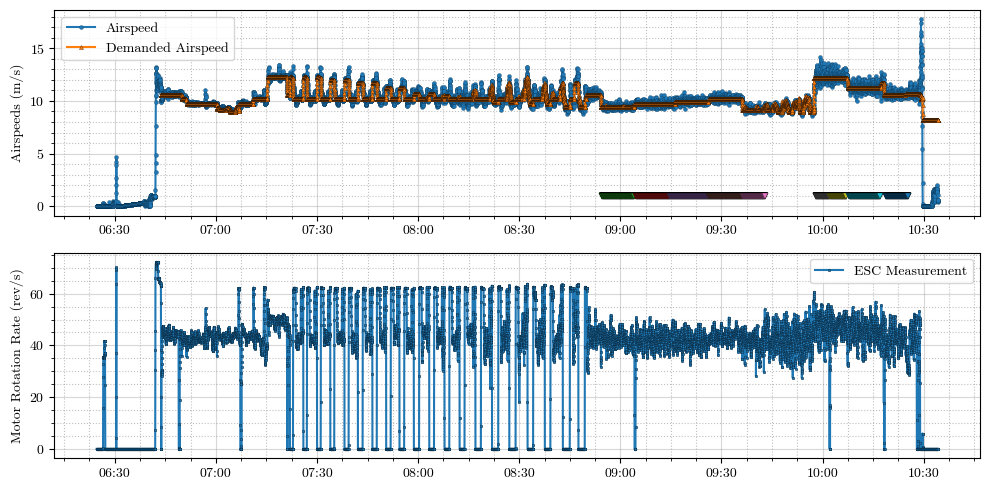

In [18]:
# Plotting time indexed flight data
# Plotting true airspeed, with demanded airspeed
plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, v_tas, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df.index, v_dem, label="Demanded Airspeed", marker='^', markeredgecolor=[0,0,0], markersize=3)
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(df_1Hz.index[segment], np.ones(len(segment)), marker='v')
ax1.set_ylabel("Airspeeds (m/s)")
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, n, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
plt.legend()

plt.show()


### <a id='toc1_10_2_'></a>[Plotting motor RPM over the selected time intervals](#toc0_)

Text(0, 0.5, 'Motor Revolutions per Second')

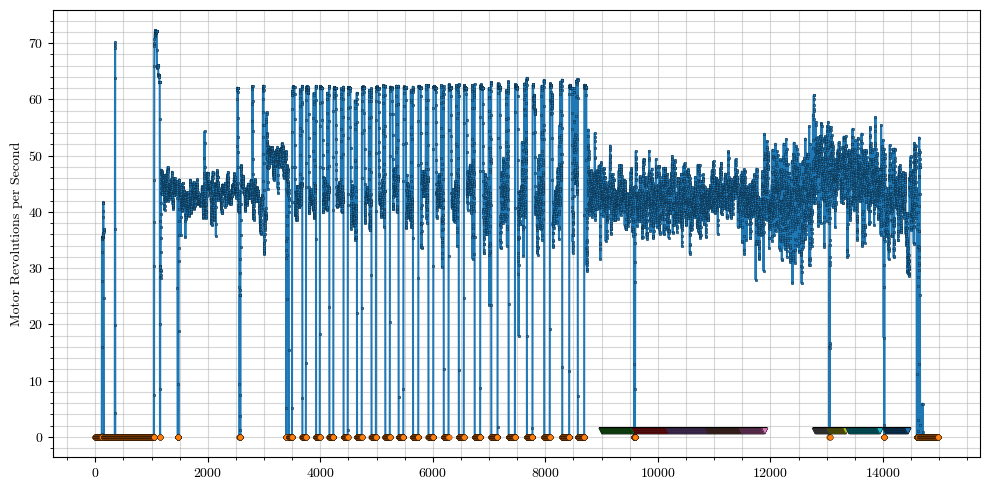

In [23]:
plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(np.transpose(np.where(n == 0)), n[n == 0], linestyle='None', marker='o', label='RPM=0')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Motor Revolutions per Second")

Above plot showing motor rev/s vs time in seconds.  Orange points represent the times where rev/s reads zero.  Coloured V's represent the cruising segments that are being used for the data reduction.  This is used to visualize where we can get good data from, if n is zero during cruise this needs to be excluded.  

### <a id='toc1_10_3_'></a>[Plotting J to see where data needs exclusion](#toc0_)

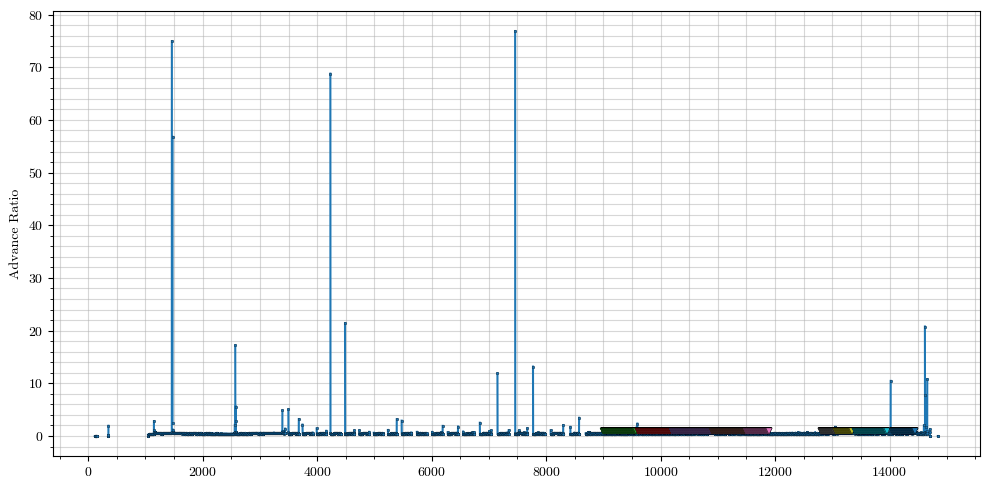

In [24]:
plt.figure(figsize=(10,5))
plt.plot(J)
plt.plot(np.transpose(np.where(n == 0)), J[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Advance Ratio")
plt.show()

Data needs exclusion around 9570, since the J is going high due to the n going to zero.  
Data needs exclusion around 13045. 

### <a id='toc1_10_4_'></a>[Plotting System Efficiency](#toc0_)

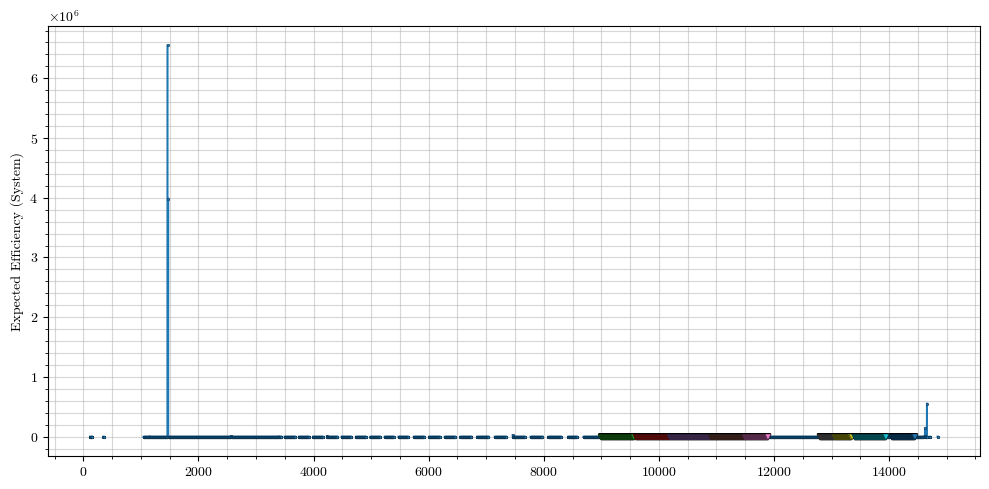

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


In [25]:
plt.figure(figsize=(10,5))
plt.plot(eff)
plt.plot(np.transpose(np.where(n == 0)), eff[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Expected Efficiency (System)")
plt.show()

Efficiency goes to infinity anytime the RPM goes low or to zero.  Same points identified earlier are a problem and need to be excluded for the $\eta$ method

### <a id='toc1_10_5_'></a>[Plotting Descent Rates, Zero RPM highlighted](#toc0_)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_55221/322705024.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,5))


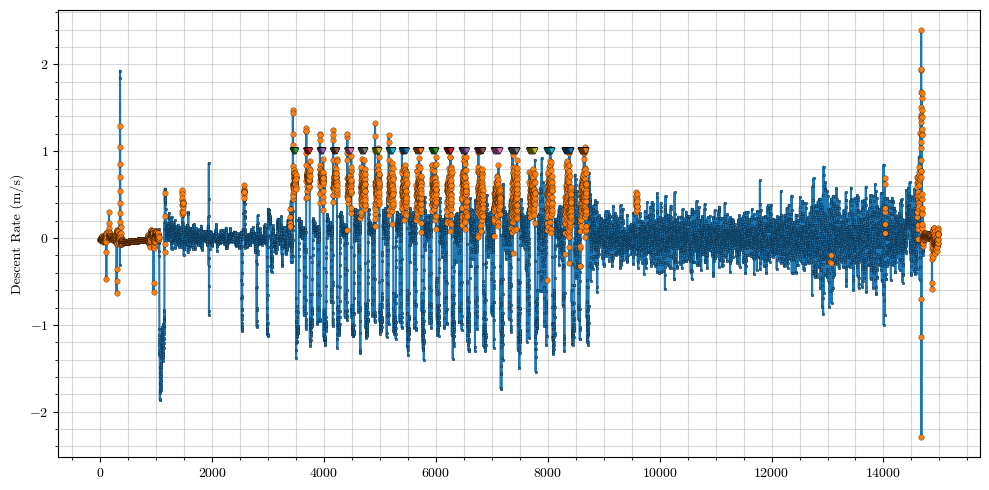

In [27]:
plt.figure(figsize=(10,5))
plt.plot(Vd_tas)
plt.plot(np.transpose(np.where(n == 0)), Vd_tas[n == 0], linestyle='None', marker='o')
for i in range(len(desc_mask)):
    segment = np.arange(desc_mask[i,0],desc_mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Descent Rate (m/s)")
plt.show()

### <a id='toc1_10_6_'></a>[Pitch and Coefficient of Lift Time Plots](#toc0_)

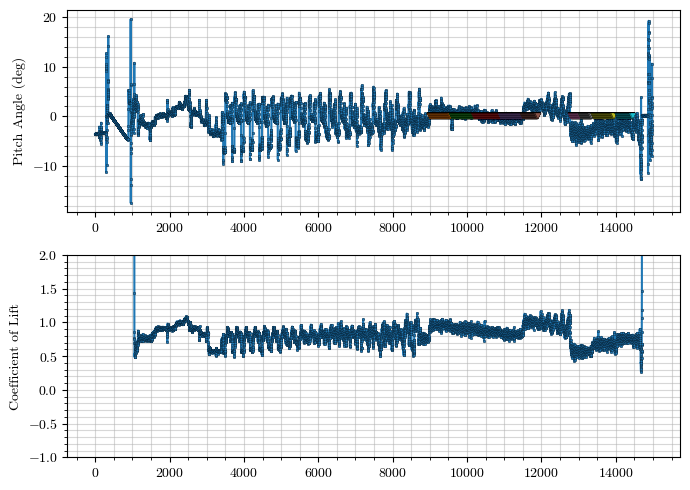

In [30]:
# Pitch and $C_L$ vs. Time (s)
plt.figure(figsize=(7,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(np.rad2deg(pitch))
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(segment, np.zeros(len(segment)), marker='v')
ax1.grid(True)
ax1.set_ylabel("Pitch Angle (deg)")

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(CL)
ax2.set_ylim([-1,2])
ax2.set_ylabel("Coefficient of Lift")

plt.show()